In [1]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import os

import functions.eddy_feedback as ef

# Reanalysis calculations (vertically-averaged)

## Reanalysis EFPs

In [2]:
path = '/home/links/ct715/data_storage/reanalysis/srip_datasets'
data_file = os.path.join(path, 'JRA55_srip_ubar_div1.nc')
jra_srip = xr.open_mfdataset(data_file, chunks={'time': 30})
jra_srip = jra_srip.sel(time=slice('1979-01', '2010-12'))

nh_efp = ef.calculate_efp(jra_srip, data_type='reanalysis', which_div1='div1_pr', slice_500hPa=True)
sh_efp = ef.calculate_efp(jra_srip, data_type='reanalysis', calc_south_hemis=True, which_div1='div1_pr', slice_500hPa=True)

print(nh_efp, sh_efp)

0.4825 0.3598


## Reanalysis variances

### NAM (AO) and SAM (AAO)

In [3]:
eofs_ds_nam = xr.open_dataset('./data/jra55/jra55_daily_u500_eofs_nh.nc')
ao = -eofs_ds_nam['pc1'].sel(mode=0)
ao = ao.sel(time=slice('1979-01', '2010-12-31'))
ao_var = ao.var().round(1).values
print('AO variance:', ao_var)

eofs_ds_sam = xr.open_dataset('./data/jra55/jra55_daily_u500_eofs_sh.nc')
aao = -eofs_ds_sam['pc1'].sel(mode=0)
aao = aao.sel(time=slice('1979-01', '2010-12-31'))
aao_var = aao.var().round(1).values
print('AAO variance:', aao_var)

AO variance: 39.8
AAO variance: 59.5


# PAMIP data
## NH vs SH EFP

In [4]:
df_efp = pd.read_csv('/home/links/ct715/eddy_feedback/chapter1/efp_random/data/500hPa_efp_13models.csv', index_col=0)

## NH EFP vs NAM variance

In [5]:
nam_data = './data/pamip_misc/pc1_variance_DJF.csv'

nam = pd.read_csv(nam_data)

# Merge the DataFrames on the 'model' column
merged_df_nam = pd.merge(nam, df_efp, left_on='model', right_on='model')

# Select only the columns you want: model, variance, and efp_nh
result_df_nam = merged_df_nam[['model', 'variance', 'efp_nh']]
df_nam = result_df_nam.rename(columns={'variance': 'nam_variance'})

# SH EFP vs SAM variance

In [6]:
sam_data = './data/pamip_misc/pc1_variance_JAS.csv'

sam = pd.read_csv(sam_data)
# Merge the DataFrames on the 'model' column
merged_df_sam = pd.merge(sam, df_efp, left_on='model', right_on='model')

# Select only the columns you want: model, variance, and efp_sh
result_df_sam = merged_df_sam[['model', 'variance', 'efp_sh']]
df_sam = result_df_sam.rename(columns={'variance': 'sam_variance'})

# NAM variance vs SAM variance

In [7]:
df = pd.merge(df_nam, df_sam, on='model', how='outer')

# All combined

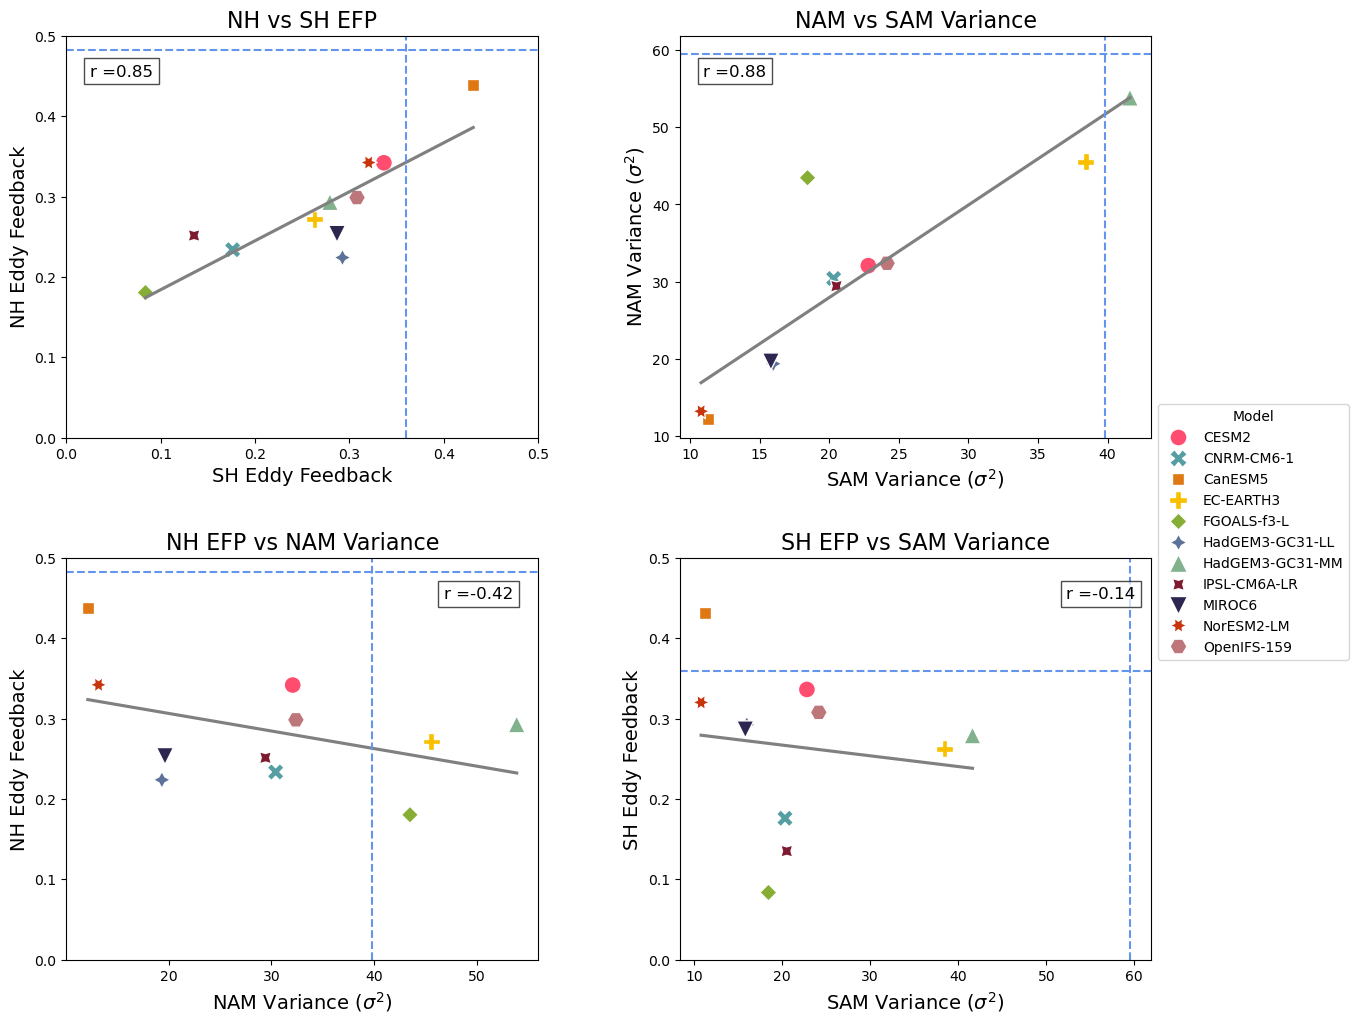

In [8]:
# colours
from pypalettes import load_cmap
cmap = load_cmap("Klein")
models = df['model'].unique()
colors = [cmap(i / (len(models) - 1)) for i in range(len(models))]
palette = dict(zip(models, colors))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ax1 (NH vs SH EFP)
sns.regplot(data=df, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None, ax=axes[0,0])
sns.scatterplot(data=df, x='efp_sh', y='efp_nh', hue='model', style='model', s=150, ax=axes[0,0], palette=palette)
r, p = sp.stats.pearsonr(x=df['efp_nh'], y=df['efp_sh'])
axes[0,0].text(.05, .9, "r ={:.2f}".format(r), transform=axes[0,0].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=12)
axes[0,0].axhline(nh_efp, linestyle='--', color='cornflowerblue')
axes[0,0].axvline(sh_efp, linestyle='--', color='cornflowerblue')
axes[0,0].set_ylabel('NH Eddy Feedback', fontsize=14)
axes[0,0].set_xlabel('SH Eddy Feedback', fontsize=14)
axes[0,0].set_title('NH vs SH EFP', fontsize=16)
axes[0,0].set_xlim(0, 0.5)
axes[0,0].set_ylim(0, 0.5)
axes[0,0].get_legend().remove()

# ax2 (NAM vs SAM variance)
sns.regplot(data=df, x='sam_variance', y='nam_variance', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None, ax=axes[0,1])
sns.scatterplot(data=df, x='sam_variance', y='nam_variance', hue='model', style='model', s=150, ax=axes[0,1], palette=palette)
r, p = sp.stats.pearsonr(x=df['nam_variance'], y=df['sam_variance'])
axes[0,1].text(.05, .9, "r ={:.2f}".format(r), transform=axes[0,1].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=12)
axes[0,1].axvline(ao_var, linestyle='--', color='cornflowerblue')
axes[0,1].axhline(aao_var, linestyle='--', color='cornflowerblue')
axes[0,1].set_ylabel('NAM Variance ($\\sigma^2$)', fontsize=14)
axes[0,1].set_xlabel('SAM Variance ($\\sigma^2$)', fontsize=14)
axes[0,1].set_title('NAM vs SAM Variance', fontsize=16)
axes[0,1].get_legend().remove()

# ax3 (NH EFP vs NAM variance)
sns.regplot(data=df_nam, y='efp_nh', x='nam_variance', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None, ax=axes[1,0])
sns.scatterplot(data=df_nam, y='efp_nh', x='nam_variance', hue='model', style='model', s=150, ax=axes[1,0], palette=palette)
r, p = sp.stats.pearsonr(x=df_nam['nam_variance'], y=df_nam['efp_nh'])
axes[1,0].text(.8, .9, "r ={:.2f}".format(r), transform=axes[1,0].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=12)
axes[1,0].axvline(ao_var, linestyle='--', color='cornflowerblue')
axes[1,0].axhline(nh_efp, linestyle='--', color='cornflowerblue')
axes[1,0].set_xlabel('NAM Variance ($\\sigma^2$)', fontsize=14)
axes[1,0].set_ylabel('NH Eddy Feedback', fontsize=14)
axes[1,0].set_ylim(0, 0.5)
axes[1,0].set_title('NH EFP vs NAM Variance', fontsize=16)
axes[1,0].get_legend().remove()

# ax4 (SH EFP vs SAM variance)
sns.regplot(data=df_sam, y='efp_sh', x='sam_variance', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None, ax=axes[1,1])
sns.scatterplot(data=df_sam, y='efp_sh', x='sam_variance', hue='model', style='model', s=150, ax=axes[1,1], palette=palette)
r, p = sp.stats.pearsonr(x=df_sam['sam_variance'], y=df_sam['efp_sh'])
axes[1,1].text(.82, .9, "r ={:.2f}".format(r), transform=axes[1,1].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=12)
axes[1,1].axvline(aao_var, linestyle='--', color='cornflowerblue')
axes[1,1].axhline(sh_efp, linestyle='--', color='cornflowerblue')
axes[1,1].set_xlabel('SAM Variance ($\\sigma^2$)', fontsize=14)
axes[1,1].set_ylabel('SH Eddy Feedback', fontsize=14)
axes[1,1].set_ylim(0, 0.5)
axes[1,1].set_title('SH EFP vs SAM Variance', fontsize=16)
axes[1,1].get_legend().remove()

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.legend(bbox_to_anchor=(1,1.4), title='Model')
plt.savefig('./plots/U500_efp_vs_variance.png', dpi=300, bbox_inches='tight')
plt.show()


# Poster plot

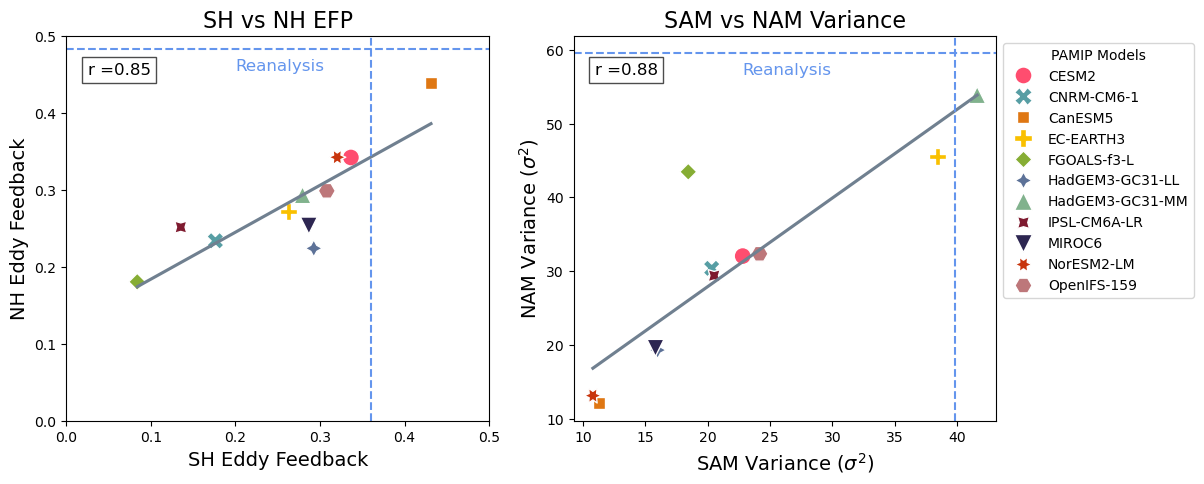

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# ax1 (NH vs SH EFP)
sns.regplot(data=df, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "slategrey"}, ci=None, ax=axes[0])
sns.scatterplot(data=df, x='efp_sh', y='efp_nh', hue='model', style='model', s=150, ax=axes[0], palette=palette)
r, p = sp.stats.pearsonr(x=df['efp_nh'], y=df['efp_sh'])
axes[0].text(.05, .9, "r ={:.2f}".format(r), transform=axes[0].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=12)
axes[0].axhline(nh_efp, linestyle='--', color='cornflowerblue')
axes[0].axvline(sh_efp, linestyle='--', color='cornflowerblue')
axes[0].text(0.4, 0.91, f'Reanalysis', transform=axes[0].transAxes,
             color='cornflowerblue', fontsize=12)
axes[0].set_ylabel('NH Eddy Feedback', fontsize=14)
axes[0].set_xlabel('SH Eddy Feedback', fontsize=14)
axes[0].set_title('SH vs NH EFP', fontsize=16)
axes[0].set_xlim(0, 0.5)
axes[0].set_ylim(0, 0.5)
axes[0].get_legend().remove()

# ax2 (NAM vs SAM variance)
sns.regplot(data=df, x='sam_variance', y='nam_variance', scatter_kws={'color': 'white'}, line_kws={"color": "slategrey"}, ci=None, ax=axes[1])
sns.scatterplot(data=df, x='sam_variance', y='nam_variance', hue='model', style='model', s=150, ax=axes[1], palette=palette)
r, p = sp.stats.pearsonr(x=df['nam_variance'], y=df['sam_variance'])
axes[1].text(.05, .9, "r ={:.2f}".format(r), transform=axes[1].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=12)
axes[1].axvline(ao_var, linestyle='--', color='cornflowerblue')
axes[1].axhline(aao_var, linestyle='--', color='cornflowerblue')
axes[1].text(0.4, 0.9, f'Reanalysis', transform=axes[1].transAxes,
             color='cornflowerblue', fontsize=12)
axes[1].set_ylabel('NAM Variance ($\\sigma^2$)', fontsize=14)
axes[1].set_xlabel('SAM Variance ($\\sigma^2$)', fontsize=14)
axes[1].set_title('SAM vs NAM Variance', fontsize=16)
axes[1].get_legend().remove()

# plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.legend(bbox_to_anchor=(1,1), title='PAMIP Models')
plt.savefig('./plots/poster-2plots_U500_efp_vs_variance.png', dpi=300, bbox_inches='tight')
plt.show()


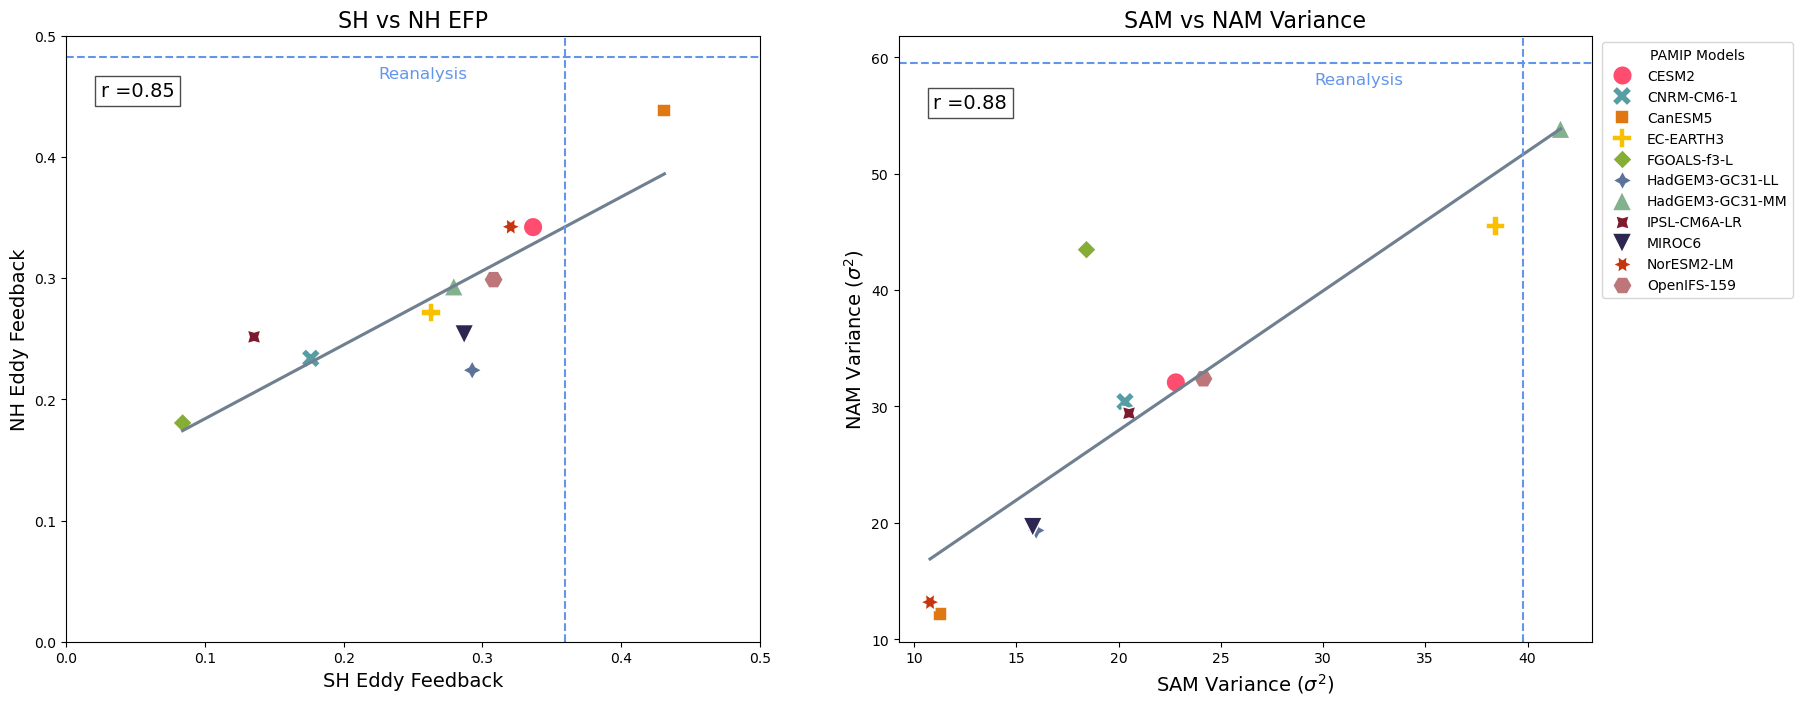

In [14]:
def mm_to_inches(mm):
    return mm / 25.4

# Example usage:
width_mm = 250  # e.g., full-page width in a journal
height_mm = 100


figsize = (mm_to_inches(width_mm*2), mm_to_inches(height_mm*2))

fig, axes = plt.subplots(ncols=2, figsize=figsize)

# ax1 (NH vs SH EFP)
sns.regplot(data=df, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "slategrey"}, ci=None, ax=axes[0])
sns.scatterplot(data=df, x='efp_sh', y='efp_nh', hue='model', style='model', s=200, ax=axes[0], palette=palette)
r, p = sp.stats.pearsonr(x=df['efp_nh'], y=df['efp_sh'])
axes[0].text(.05, .9, "r ={:.2f}".format(r), transform=axes[0].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=14)
axes[0].axhline(nh_efp, linestyle='--', color='cornflowerblue')
axes[0].axvline(sh_efp, linestyle='--', color='cornflowerblue')
axes[0].text(0.45, 0.93, f'Reanalysis', transform=axes[0].transAxes,
             color='cornflowerblue', fontsize=12)
axes[0].set_ylabel('NH Eddy Feedback', fontsize=14)
axes[0].set_xlabel('SH Eddy Feedback', fontsize=14)
axes[0].set_title('SH vs NH EFP', fontsize=16)
axes[0].set_xlim(0, 0.5)
axes[0].set_ylim(0, 0.5)
axes[0].get_legend().remove()

# ax2 (NAM vs SAM variance)
sns.regplot(data=df, x='sam_variance', y='nam_variance', scatter_kws={'color': 'white'}, line_kws={"color": "slategrey"}, ci=None, ax=axes[1])
sns.scatterplot(data=df, x='sam_variance', y='nam_variance', hue='model', style='model', s=200, ax=axes[1], palette=palette)
r, p = sp.stats.pearsonr(x=df['nam_variance'], y=df['sam_variance'])
axes[1].text(.05, .88, "r ={:.2f}".format(r), transform=axes[1].transAxes, 
               bbox=dict(facecolor="white", alpha=0.7), fontsize=14)
axes[1].axvline(ao_var, linestyle='--', color='cornflowerblue')
axes[1].axhline(aao_var, linestyle='--', color='cornflowerblue')
axes[1].text(0.6, 0.92, f'Reanalysis', transform=axes[1].transAxes,
             color='cornflowerblue', fontsize=12)
axes[1].set_ylabel('NAM Variance ($\\sigma^2$)', fontsize=14)
axes[1].set_xlabel('SAM Variance ($\\sigma^2$)', fontsize=14)
axes[1].set_title('SAM vs NAM Variance', fontsize=16)
axes[1].get_legend().remove()

# plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.legend(bbox_to_anchor=(1.005,1), title='PAMIP Models')
# Save with exact size
plt.savefig(
    './plots/poster-2plots_U500_efp_vs_variance.png',
    dpi=300,
    bbox_inches='tight',  # use 'tight' only if you want to trim whitespace
    pad_inches=0.01        # adjust this if tight cuts off things too close to the edge
)
plt.show()
